[View in Colaboratory](https://colab.research.google.com/github/DavyliPython/DeepLearning/blob/master/DigitRe.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
sns.set(style='white', context='notebook', palette='deep')

In [3]:
!pip install kaggle_cli

In [4]:
!kg download -u sheman2001 -p 35433011 -c digit-recognizer -f train.csv

downloading https://www.kaggle.com/c/digit-recognizer/download/train.csv

train.csv already downloaded !


In [5]:
!kg download -u sheman2001 -p 35433011 -c digit-recognizer -f test.csv

downloading https://www.kaggle.com/c/digit-recognizer/download/test.csv

test.csv already downloaded !


In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
!dir

cnn_mnist_datagen.csv  datalab	test.csv  train.csv


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

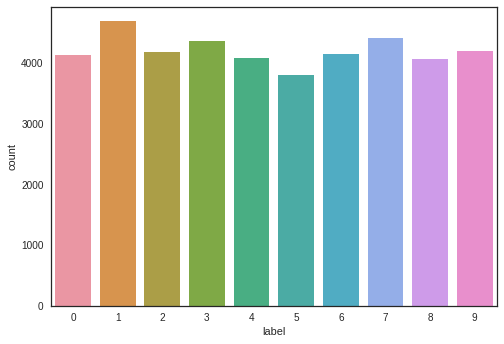

In [8]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [9]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [11]:
X_train = X_train / 255.0
test = test / 255.0

In [12]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [13]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [14]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

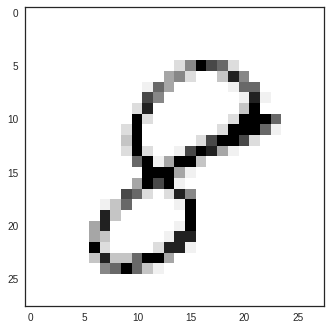

In [15]:
g = plt.imshow(X_train[0][:,:,0])

In [16]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [17]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 50 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [19]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 15s - loss: 0.4192 - acc: 0.8659 - val_loss: 0.0702 - val_acc: 0.9802
Epoch 2/50
 - 14s - loss: 0.1359 - acc: 0.9595 - val_loss: 0.0372 - val_acc: 0.9876
Epoch 3/50
 - 14s - loss: 0.0972 - acc: 0.9710 - val_loss: 0.0440 - val_acc: 0.9907
Epoch 4/50
 - 14s - loss: 0.0817 - acc: 0.9769 - val_loss: 0.0354 - val_acc: 0.9893
Epoch 5/50
 - 14s - loss: 0.0725 - acc: 0.9785 - val_loss: 0.0419 - val_acc: 0.9848
Epoch 6/50
 - 14s - loss: 0.0684 - acc: 0.9797 - val_loss: 0.0248 - val_acc: 0.9914
Epoch 7/50
 - 14s - loss: 0.0620 - acc: 0.9821 - val_loss: 0.0284 - val_acc: 0.9907
Epoch 8/50
 - 14s - loss: 0.0604 - acc: 0.9821 - val_loss: 0.0335 - val_acc: 0.9919
Epoch 9/50
 - 14s - loss: 0.0593 - acc: 0.9829 - val_loss: 0.0182 - val_acc: 0.9921
Epoch 10/50
 - 13s - loss: 0.0613 - acc: 0.9825 - val_loss: 0.0223 - val_acc: 0.9921
Epoch 11/50
 - 14s - loss: 0.0617 - acc: 0.9831 - val_loss: 0.0241 - val_acc: 0.9945
Epoch 12/50
 - 14s - loss: 0.0559 - acc: 0.9845 - val_loss: 0.0229 - val_a

 - 14s - loss: 0.0310 - acc: 0.9916 - val_loss: 0.0170 - val_acc: 0.9948

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 34/50
 - 14s - loss: 0.0291 - acc: 0.9915 - val_loss: 0.0182 - val_acc: 0.9952
Epoch 35/50
 - 14s - loss: 0.0290 - acc: 0.9921 - val_loss: 0.0184 - val_acc: 0.9952
Epoch 36/50
 - 14s - loss: 0.0308 - acc: 0.9913 - val_loss: 0.0178 - val_acc: 0.9950

Epoch 00036: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 37/50
 - 14s - loss: 0.0302 - acc: 0.9916 - val_loss: 0.0186 - val_acc: 0.9952
Epoch 38/50
 - 14s - loss: 0.0289 - acc: 0.9919 - val_loss: 0.0183 - val_acc: 0.9955
Epoch 39/50
 - 14s - loss: 0.0305 - acc: 0.9916 - val_loss: 0.0179 - val_acc: 0.9955
Epoch 40/50
 - 14s - loss: 0.0315 - acc: 0.9916 - val_loss: 0.0185 - val_acc: 0.9952
Epoch 41/50
 - 14s - loss: 0.0282 - acc: 0.9919 - val_loss: 0.0185 - val_acc: 0.9952
Epoch 42/50
 - 14s - loss: 0.0328 - acc: 0.9912 - val_loss: 0.0180 - val_acc: 0.9952
Epoch 43/50
 - 

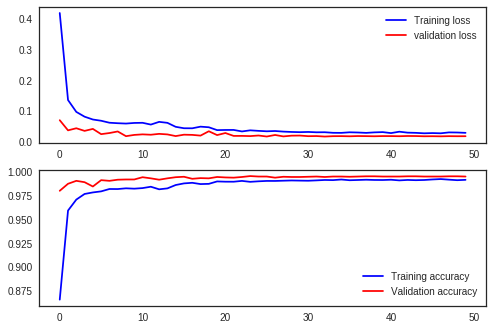

In [20]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [0]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

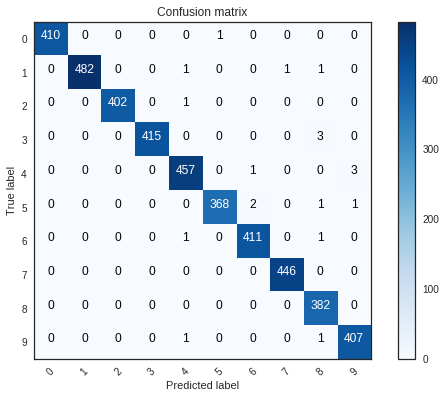

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

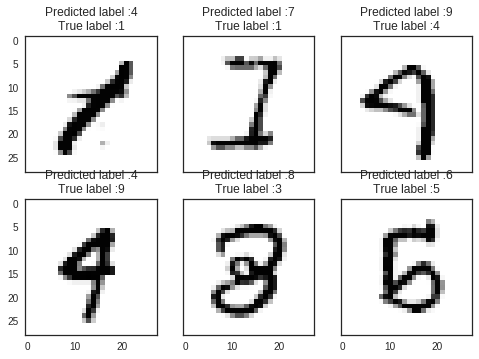

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [0]:
submission

In [0]:
!kg submit -u sheman2001 -p 35433011 -c digit-recognizer cnn_mnist_datagen.csv

In [0]:
!pip install kaggle

In [0]:
!pip install files

In [25]:
from google.colab import files
files.download('cnn_mnist_datagen.csv') 

In [0]:
!kaggle competitions submit -c digit-recognizer -f cnn_mnist_datagen.csv -m "Message"
